# Auto Capacitación Python ML PyCaret - CLASSIFICATION
Obj: predicción eventos de mantenimiento no programado en Compresores<br>
https://github.com/pycaret/pycaret/blob/time_series/examples/PyCaret%202%20Customer%20Churn%20Prediction.ipynb

In [ ]:
# balanceo de clases: SMOTE o subsampling. https://github.com/institutohumai/cursos-python clase de clasificación ver datos desbalanceados.
# https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/4_Clasificacion/Clasificacion.ipynb

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

In [3]:
import datetime
from datetime import timedelta

In [4]:
import re

In [5]:
#!pip install pandas-profiling --upgrade version 3.1.0 2022.01.16
import pandas_profiling as pp

In [6]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

https://pycaret.gitbook.io/docs/get-started/quickstart<br>
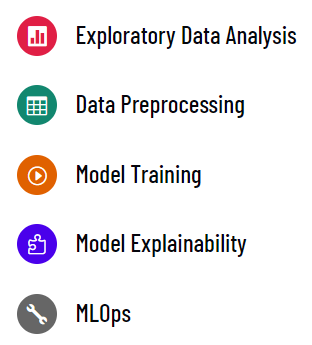

# Data Import
Como se trata de la importación de los datos para el modelado, no es un trabajo repetitivo, se bajan los datos de PI utilizando datalink. Los datos quedan en un csv que se importa en este notebook.
Como los datos vienen para un mismo timestamp, una columna por elemento (compresor) y tag, se debe hacer una especie de trasposición para que los datos queden utilizables (de datalink el id del compresor viene en el nombre del tag, o sea, en el nombre de la columna y no como un dato en la columna "compresor", se debe agregar esta columna)

In [6]:
import locale
locale.getlocale()

('Spanish_Argentina', '1252')

In [7]:
path_data = 'C:\\Users\\COLMO\\data_mining\\data_pampa'

In [8]:
file = 'EMA_compresores_diario_zafiro.csv'
# Bajada de SQL con estas columnas: 
# equipment_id, Equipo, Dia_Operativo, Comentarios, Estado, Mantenimiento_Programado, Mantenimiento_No_Programado, En_Reserva, En_Marcha,
# Rpm, facility_eqp_parameter_energy_generation, Presion_Succion, Presion_Descarga, Temperatura_Succion, Temperatura_Descarga, Caudal,
# es_overhaul

In [9]:
# 'windows-1251' UTF-8 trae bien los caracteres especiales del castellano
df_diario = pd.read_csv(path_data + '\\' + file, sep=';', encoding='UTF-8', index_col=False,
                        names=['equipment_id', 'element', 'timestamp', 'comments', 'estado', 'mant_prog', 'mant_no_prog', 
                               'en_reserva', 'en_marcha', 'rpm', 
                               'press_succ', 'press_desc', 'temp_succ', 'temp_desc', 'caudal', 'es_overhaul'])
##### Se acota el trabajo a los compresores de EMA:
element_lst = ['k-01', 'k-02', 'k-03', 'k-04', 'k-05', 'k-06', 'k-07', 'k-08', 'k-09']
df_diario = df_diario[df_diario.element.str.lower().isin(element_lst)]
df_diario.shape

(21737, 16)

In [10]:
df_diario.tail()

,equipment_id,element,timestamp,comments,estado,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_succ,press_desc,temp_succ,temp_desc,caudal,es_overhaul
23310,116,K-09,2022-01-19 00:00:00.000,,En Funcionamiento,0,0,"3,5","20,5",1100,NaN,"6,1",35,18,"102,3",NaN
23311,116,K-09,2022-01-20 00:00:00.000,"E/S 22:10hs,recuperar caudal de venta tras pue...",En Reserva,0,0,24,0,0,NaN,0,0,0,0,NaN
23312,116,K-09,2022-01-21 00:00:00.000,09:00hs a 20:30hs E/S.,En Funcionamiento,0,0,13,11,0,NaN,0,0,0,0,NaN
23313,116,K-09,2022-01-22 00:00:00.000,,En Reserva,0,0,24,0,0,NaN,0,0,0,0,NaN
23314,116,K-09,2022-01-23 00:00:00.000,,En Reserva,0,0,24,0,0,NaN,0,0,0,0,NaN


# EDA con Pandas Profiling
https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/

In [12]:
df_diario.columns

Index(['equipment_id', 'element', 'timestamp', 'comments', 'estado',
       'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm',
       'press_succ', 'press_desc', 'temp_succ', 'temp_desc', 'caudal',
       'es_overhaul'],
      dtype='object')

In [13]:
# Antes del EDA, se corrigen algunos tipos de datos
df_diario.dtypes

equipment_id      int64
element          object
timestamp        object
comments         object
estado           object
mant_prog        object
mant_no_prog     object
en_reserva       object
en_marcha        object
rpm              object
press_succ      float64
press_desc       object
temp_succ        object
temp_desc        object
caudal           object
es_overhaul     float64
dtype: object

In [11]:
# timestamp
#print(pd.to_datetime('2021-08-15 00:00:00.000', dayfirst=True, format='%Y-%m-%d %H:%M:%S'))
df_diario.timestamp = pd.to_datetime(df_diario.timestamp, format='%Y-%m-%d %H:%M:%S')

In [12]:
# comments: 
print('Los comentarios Nan se convierten a Sin Novedades', df_diario.comments.isna().sum()) #2573
df_diario.comments.fillna('Sin Novedades', inplace=True)

Los comentarios Nan se convierten a Sin Novedades 13886


In [14]:
columns = list(df_diario.columns[5:10]) + list(df_diario.columns[11:-1])
columns

['mant_prog',
 'mant_no_prog',
 'en_reserva',
 'en_marcha',
 'rpm',
 'press_desc',
 'temp_succ',
 'temp_desc',
 'caudal']

In [15]:
# Los datos tipo float vienen con ',' como separador decimal. Se reemplaza por '.' para poder convertir a float
# lista de campos tipo float:
columns = list(df_diario.columns[5:10]) + list(df_diario.columns[11:-1])
print(columns)
for column in columns:
    df_diario[column] = df_diario[column].str.replace(',', '.')
    df_diario[column] = df_diario[column].astype('float64' , copy=True)
print(df_diario.dtypes)
df_diario.head()

['mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm', 'press_desc', 'temp_succ', 'temp_desc', 'caudal']
equipment_id             int64
element                 object
timestamp       datetime64[ns]
comments                object
estado                  object
mant_prog              float64
mant_no_prog           float64
en_reserva             float64
en_marcha              float64
rpm                    float64
press_succ             float64
press_desc             float64
temp_succ              float64
temp_desc              float64
caudal                 float64
es_overhaul            float64
dtype: object


,equipment_id,element,timestamp,comments,estado,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_succ,press_desc,temp_succ,temp_desc,caudal,es_overhaul
0,25,K-01,2013-07-01,Dato Migrado -,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
1,25,K-01,2013-07-02,Dato Migrado -,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
2,25,K-01,2013-07-03,Dato Migrado -,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
3,25,K-01,2013-07-04,Dato Migrado -,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN
4,25,K-01,2013-07-05,Dato Migrado -,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN


In [19]:
# pandas_profiling tiene un bug con pandas 1.4 - Sólo funciona colocando minimal=True, pero no calcula los 
# gráficos de relaciones entre variables
pp.ProfileReport(df_diario, minimal=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Matriz de Correlación

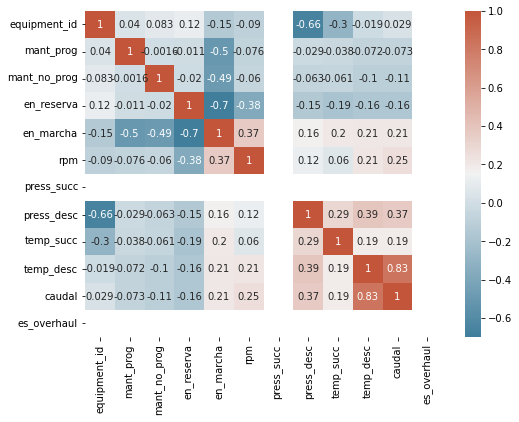

In [17]:
#method{‘pearson’, ‘kendall’, ‘spearman’} default pearson
corr = df_diario.corr(method='pearson')
%matplotlib inline
plt.figure(figsize=(8, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()

In [30]:
df_diario.corr()

,equipment_id,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_succ,press_desc,temp_succ,temp_desc,caudal,es_overhaul
equipment_id,1.000000,0.040118,0.083350,0.117131,-0.146032,-0.090370,NaN,-0.661168,-0.297117,-0.019013,0.029242,NaN
mant_prog,0.040118,1.000000,-0.001612,-0.011131,-0.501259,-0.075767,NaN,-0.029202,-0.037531,-0.072489,-0.072558,NaN
mant_no_prog,0.083350,-0.001612,1.000000,-0.019711,-0.488426,-0.059571,NaN,-0.063150,-0.060968,-0.104135,-0.107554,NaN
en_reserva,0.117131,-0.011131,-0.019711,1.000000,-0.698299,-0.377125,NaN,-0.153265,-0.192931,-0.163130,-0.163143,NaN
en_marcha,-0.146032,-0.501259,-0.488426,-0.698299,1.000000,0.366334,NaN,0.163536,0.198944,0.206323,0.208311,NaN
rpm,-0.090370,-0.075767,-0.059571,-0.377125,0.366334,1.000000,NaN,0.121872,0.060236,0.212968,0.252913,NaN
press_succ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
press_desc,-0.661168,-0.029202,-0.063150,-0.153265,0.163536,0.121872,NaN,1.000000,0.293986,0.385678,0.367635,NaN
temp_succ,-0.297117,-0.037531,-0.060968,-0.192931,0.198944,0.060236,NaN,0.293986,1.000000,0.187374,0.185877,NaN
temp_desc,-0.019013,-0.072489,-0.104135,-0.163130,0.206323,0.212968,NaN,0.385678,0.187374,1.000000,0.830382,NaN


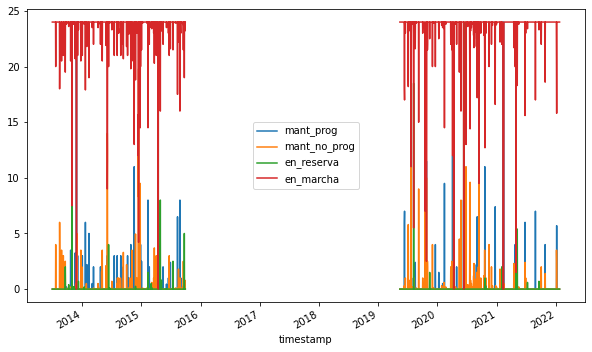

In [18]:
# x_compat=True mejora la forma en que se muestran las fechas
%matplotlib inline
df_diario[(df_diario.element=='K-01')]\
    [['element', 'timestamp', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].plot(x='timestamp', 
                                                                                            figsize=(10, 6),
                                                                                            x_compat=True);

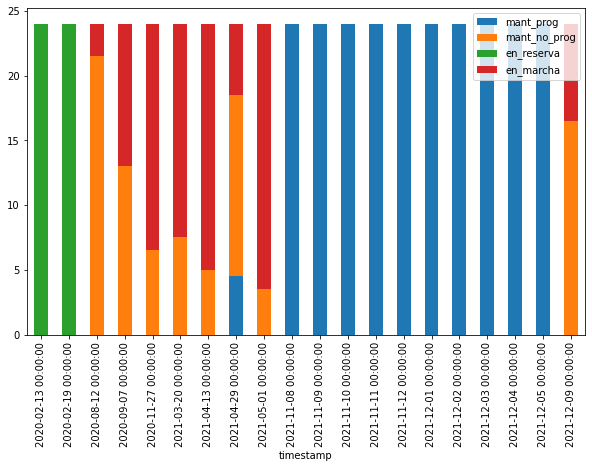

In [21]:
df_diario[(df_diario.element=='K-09') & (df_diario.timestamp > '2020-01-01') & (df_diario.estado == 'Fuera de Servicio')]\
    [['element', 'timestamp', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].plot(x='timestamp',
                                                                                            kind='bar', 
                                                                                            stacked=True,
                                                                                            figsize=(10, 6));
                                                                                            #, x_compat=True);

# Data Wrangling
Toma a todas las variables como categóricas --> asignarles un tipo <br>
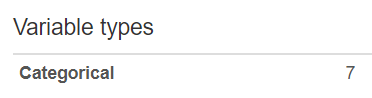
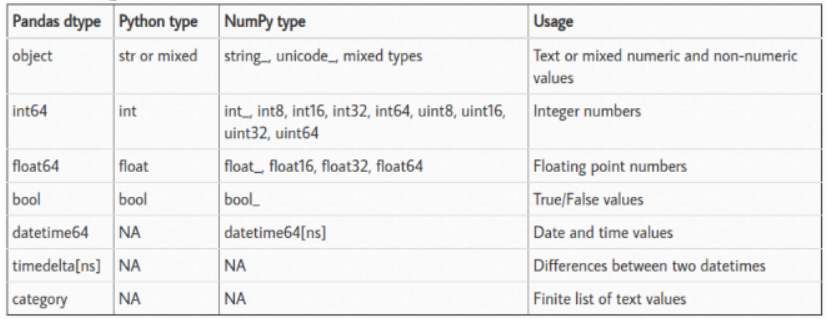

## Dataset de Datos Diarios (Zafiro)

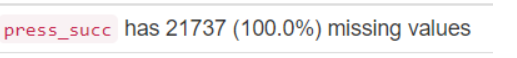 La columna es_overhaul está en la misma situación

In [ ]:
# En base a resultados de EDA, se ajustan los nan:

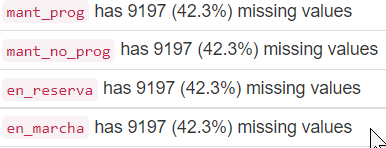

In [19]:
# 9197 registros sin datos horarios.
df_diario[(df_diario.mant_prog.isna()) & (df_diario.mant_no_prog.isna()) & (df_diario.en_reserva.isna())
         & (df_diario.en_marcha.isna())]\
    [['element', 'timestamp', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].shape

(9197, 6)

In [20]:
print('registros con nan en horas, desde:', df_diario[(df_diario.mant_prog.isna()) & (df_diario.mant_no_prog.isna()) & (df_diario.en_reserva.isna())
         & (df_diario.en_marcha.isna())].timestamp.min(), 'hasta:')
df_diario[(df_diario.mant_prog.isna()) & (df_diario.mant_no_prog.isna()) & (df_diario.en_reserva.isna())
         & (df_diario.en_marcha.isna())].timestamp.max()

registros con nan en horas, desde: 2015-09-30 00:00:00 hasta:


Timestamp('2019-05-13 00:00:00')

In [21]:
# press_succ en EMA no tiene datos --> se elimina la columna
# Se asignan los registros sin nan a otro dataframe, sin la columna press_succ
df_data = df_diario[(df_diario.mant_prog.notna())][['equipment_id', 'element', 'timestamp', 'estado', 
                                                 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm',
                                                 'press_desc', 'temp_succ', 'temp_desc', 'caudal']].copy()
df_data.shape

(12540, 13)

In [222]:
#******************************************************************************************
# NOTA: no se vá a utilizar el estado para esta primer prueba!!! no continúo corrigiéndolo
#******************************************************************************************
# Estado tiene 3719 registros nan. Luego que eliminar registros sin datos horarios, quedan 3706
# Estado nan y en_marcha = 24 --> estado='En Funcionamiento' 2701
print('registros con estado nan:', df_data[df_data.estado.isna()].shape)
print('equipos con estado nan:', pd.unique(df_data[(df_data.estado.isna())].element.to_list()))
print('registros con estado nan y horas en marcha=24 --> estado En Funcionamiento', 
      df_data[(df_data.estado.isna()) & (df_data.en_marcha==24)]\
    [['element', 'timestamp', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].shape)

registros con estado nan: (3706, 13)
equipos con estado nan: ['K-01' 'K-02' 'K-03' 'K-04' 'K-05' 'K-06' 'K-07' 'K-08' 'K-09']
registros con estado nan y horas en marcha=24 --> estado En Funcionamiento (2701, 6)


In [223]:
# Se asigna el estado 'En Funcionamiento'
df_data.loc[(df_data.estado.isna()) & (df_data.en_marcha==24), 'estado'] ='En Funcionamiento'

In [224]:
df_data[(df_data.estado.isna())]\
    [['element', 'timestamp', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].shape

(1005, 6)

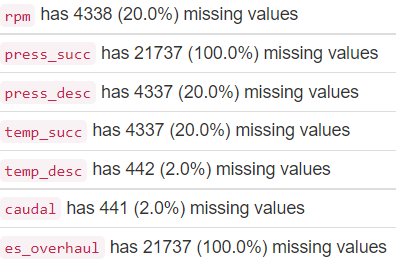

In [152]:
#**********************************************************************************
# No se corrigen estos datos para ver cómo los manejan los algoritmos (en estos regitros se cuenta con datos horarios)
#**********************************************************************************
# rpm nulos, luego de sacar registros con horas en nan: 4004
print('rpm nulos, luego de sacar registros con horas en nan:', data[data.rpm.isna()].shape[0])
# Cuándo rpm es nulo qué pasa con las variables de horas? 404 registros
# Hay 167 registros con todos los datos en nan --> se eliminan
# La falta del dato de rpms no siempre coincide con días en que estuvo parado (hay varios días de 23 hs de marcha)
# Cuando rpm es nulo, press_succ y press_desc también lo son --> se borran esos elementos
#df_diario[(df_diario.rpm.isna()) & (df_diario.en_marcha > 0)][['element', 'timestamp', 'mant_prog', 'mant_no_prog', 
df_diario[(df_diario.rpm.isna()) & (df_diario.press_desc.isna()) & (df_diario.press_succ.isna())
         & (df_diario.temp_desc.isna()) & (df_diario.temp_succ.isna()) & (df_diario.en_marcha.isna())]\
    [['element', 'timestamp', 'mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha']].shape

rpm nulos, luego de sacar registros con horas en nan: 4004


(167, 6)

# Classification
Es posible tratar este problema como un problema de clasificación? Ej: el compresor va a tener un mantenimiento no planificado en el próximo período (Si/No)? <br>
ERROR de pensamiento: para que un modelo de clasificación me diga si en el próximo período el tendré mant no prog, le tengo que pasar los valores de todo el registro (incluida la cantidad de horas de mant no programado!) con lo cual, no sirve.<br>
Hay que pensarlo como lo hizo el profesor de data mining: a cada día, colocarle en label si el día siguiente (o dentro de x días) tuvo un mant no programado!!!

https://pycaret.gitbook.io/docs/get-started/quickstart#classification

## 1- Preparación del Dataset
### Incorporación de la columna Objetivo y columna valor Objetivo en 7 días

In [22]:
# Para un algoritmo de clasificación se necesita una columna objetivo que presente la clase en el dataset de entrenamiento
# La clase en el problema de mantenimiento no programado en compresores, la clase podría ser si en ese día el compresor
# tuvo o no horas de mantenimiento no planificado.
df_data['class'] = df_data.mant_no_prog.apply(lambda x: x > 0)
print(df_data.shape)
df_data[['element', 'timestamp', 'mant_no_prog', 'class']].tail()

(12540, 14)


,element,timestamp,mant_no_prog,class
23310,K-09,2022-01-19,0.0,False
23311,K-09,2022-01-20,0.0,False
23312,K-09,2022-01-21,0.0,False
23313,K-09,2022-01-22,0.0,False
23314,K-09,2022-01-23,0.0,False


In [23]:
# Prueba de resta de fechas
n_period = -7
fecha = df_data.loc[0].timestamp
fecha_anterior = fecha + timedelta(days=n_period)
print(fecha, fecha_anterior)

2013-07-01 00:00:00 2013-06-24 00:00:00


In [24]:
################################## INDICAR EL PERÍODO PREVIO CON QUE SE QUIERE PREDECIR ############################
n_period = -7 # (EN DÍAS)
####################################################################################################################

In [25]:
df_aux_prev = df_data[['element', 'timestamp', 'class']].copy()
df_aux_prev['prev_timestamp'] = df_data.timestamp.apply(lambda x: x + timedelta(days=n_period))
df_aux = pd.merge(left = df_data, right = df_aux_prev, left_on = ['element', 'timestamp'], 
                                                       right_on = ['element', 'prev_timestamp'], 
                  how = 'inner', suffixes=['_l', '_r'])
df_aux.columns

Index(['equipment_id', 'element', 'timestamp_l', 'estado', 'mant_prog',
       'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm', 'press_desc',
       'temp_succ', 'temp_desc', 'caudal', 'class_l', 'timestamp_r', 'class_r',
       'prev_timestamp'],
      dtype='object')

In [26]:
data = df_aux[['equipment_id', 'element', 'timestamp_l', 'estado', 'mant_prog',
       'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm', 'press_desc',
       'temp_succ', 'temp_desc', 'caudal', 'class_l', 'class_r']].rename(columns={'timestamp_l': 'timestamp', 
                                                                                  'class_l': 'class',
                                                                                  'class_r': 'class_pred'})
data.tail()

,equipment_id,element,timestamp,estado,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_desc,temp_succ,temp_desc,caudal,class,class_pred
12356,116,K-09,2022-01-12,En Funcionamiento,0.0,4.4,0.0,19.6,10500.0,6.2,36.1,22.0,112.0,True,False
12357,116,K-09,2022-01-13,En Funcionamiento,0.0,0.0,12.2,11.8,1100.0,6.4,35.4,22.6,105.9,False,False
12358,116,K-09,2022-01-14,En Reserva,0.0,0.0,19.5,4.5,0.0,0.0,0.0,0.0,0.0,False,False
12359,116,K-09,2022-01-15,En Reserva,0.0,0.0,18.8,5.2,0.0,0.0,0.0,0.0,0.0,False,False
12360,116,K-09,2022-01-16,En Reserva,0.0,0.0,24.0,0.0,NaN,NaN,NaN,NaN,NaN,False,False


In [27]:
data.dtypes

equipment_id             int64
element                 object
timestamp       datetime64[ns]
estado                  object
mant_prog              float64
mant_no_prog           float64
en_reserva             float64
en_marcha              float64
rpm                    float64
press_desc             float64
temp_succ              float64
temp_desc              float64
caudal                 float64
class                     bool
class_pred                bool
dtype: object

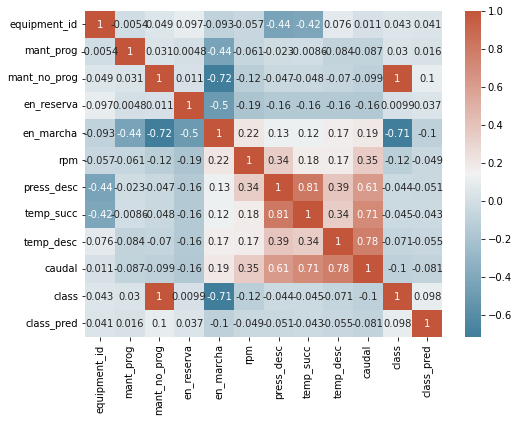

In [28]:
#method{‘pearson’, ‘kendall’, ‘spearman’} default pearson
# la correlación entre mant_no_prog debería ser 1 con la clase. Sólo el método de spearman lo calcula así:
corr = data.corr(method='spearman') 
plt.figure(figsize=(8, 6))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
#sns.heatmap(corr, cmap="Greens", annot=True)
sns.heatmap(corr, cmap=cmap, annot=True)
plt.show()

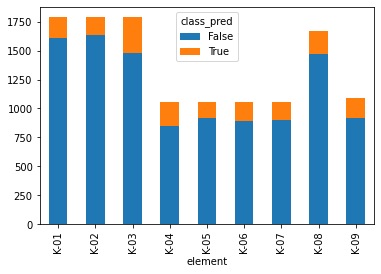

In [29]:
# When the dataset is imbalanced (ver abajo) Accuracy is NOT a good metric for consideration.
data.groupby(['element', 'class_pred']).size().unstack().plot(kind='bar', stacked=True);

## 2- Elaboración del Modelo

In [30]:
from pycaret.classification import *

**Label Encoded:** indica si la clase tuvo que ser convertida, y cómo fue la conversión (True=1, False= 0) <br>
**Transformed Train Set:** Displays the shape of the transformed training set. Notice that the original shape of (12540, 12) is transformed into (8777, 42) for the transformed train set and the number of features have increased to 42 from 13 due to categorical encoding

**Transformed Test Set:** Displays the shape of the transformed test/hold-out set. There are 3763 samples in test/hold-out set. This split is based on the default value of 70/30 that can be changed using the train_size parameter in setup.

### 2.1- Setting up PyCaret Env.
PyCaret's inference algorithm will automatically infer the data types for all features based on certain properties. 
* numeric_imputation: indicar con qué reemplazar nan en features numéricas
* ignore_features: list. ignore features during model training.
* normalize: bool, default = False. normalize numeric features. normalize_method: str, default = ‘zscore’ z = (x - u) / s. 'minmax': scales and translates each feature individually such that it is in the range of 0 - 1.
* fix_imbalance: bool, default = False. fix_imbalance_method: ‘imblearn’ o None (en cuyo caso, si fix_imbalance=True, SMOTE)

In [31]:
exp_clf1 = setup(data = data, target = 'class_pred', session_id=786, train_size=0.7, numeric_imputation='mean'
                 , fix_imbalance=True
                )

,Description,Value
0,session_id,786
1,Target,class_pred
2,Target Type,Binary
3,Label Encoded,"False: 0, True: 1"
4,Original Data,"(12361, 15)"
5,Missing Values,1
6,Numeric Features,9
7,Categorical Features,4
8,Ordinal Features,0
9,High Cardinality Features,0


In [51]:
data.isna().any()

equipment_id    False
element         False
timestamp       False
estado           True
mant_prog       False
mant_no_prog    False
en_reserva      False
en_marcha       False
rpm              True
press_desc       True
temp_succ        True
temp_desc        True
caudal           True
class           False
class_pred      False
dtype: bool

https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/<br>
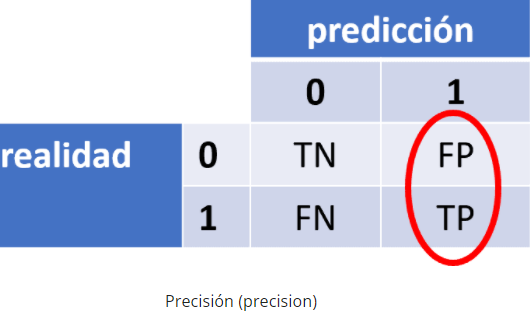
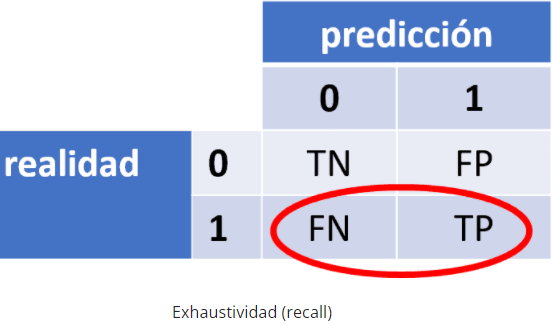

### 2.2- Train all models in the model library and scores them using stratified cross validation for metric evaluation.
The grid by default is sorted using 'Accuracy' (highest to lowest) which can be changed by passing the sort parameter. For example compare_models(sort = 'Recall') 
* If you want to change the fold parameter from the default value of 10: compare_models(fold = 5) Reducing the number of folds will improve the training time.
* precision: % de los estimados como verdaderos están bien clasificados. Mejor = cercano a 1. "calidad" de la predicción: ¿qué porcentaje de los que hemos dicho que son la clase positiva, en realidad lo son?
* Recall: % de estimados verdaderos bien estimados. cantidad: ¿qué porcentaje de la clase positiva hemos sido capaces de identificar?
* Accuracy: porcentaje de casos que el modelo ha acertado.
* F1 combina Precision y Recall en una sola medida
* AUC is the area under the receiver operating characteristic curve (ROC curve), which is 1.0 for ideal classifiers and 0.5 for those that do no better than random guessing. 

In [33]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


### IMPORTANTE: en datasets desbalanceados como el actual, el Accuracy no es el mejor indicador.
No sé cómo impacta si el dataset desbalanceado se corrije.

In [32]:
best_model = compare_models() #sort = 'Recall'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8608,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0450
lightgbm,Light Gradient Boosting Machine,0.8576,0.6348,0.0872,0.4468,0.1453,0.1044,0.1476,0.2550
gbc,Gradient Boosting Classifier,0.8549,0.6109,0.0956,0.4157,0.1547,0.1079,0.1441,1.1810
rf,Random Forest Classifier,0.8487,0.5889,0.0997,0.3529,0.1548,0.0992,0.1240,0.6590
et,Extra Trees Classifier,0.8384,0.5737,0.1130,0.2910,0.1624,0.0922,0.1049,0.7520
ada,Ada Boost Classifier,0.8281,0.5848,0.1262,0.2653,0.1648,0.0846,0.0935,0.3550
dt,Decision Tree Classifier,0.7742,0.5446,0.2284,0.2119,0.2197,0.0880,0.0881,0.0830
nb,Naive Bayes,0.7398,0.6015,0.3157,0.2104,0.2518,0.1023,0.1056,0.0500
knn,K Neighbors Classifier,0.6321,0.5790,0.4527,0.1774,0.2549,0.0688,0.0823,0.2390
lr,Logistic Regression,0.5957,0.6141,0.5540,0.1840,0.2761,0.0850,0.1098,1.4980


La primer ejecución dá esto SIN CORRECCIÓN POR DESBALANCE: qda es el mejor modelo según recall.
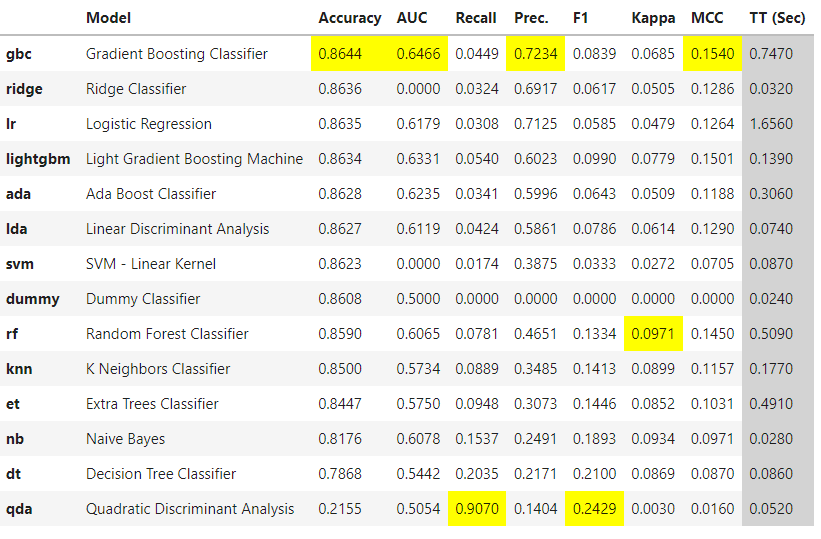
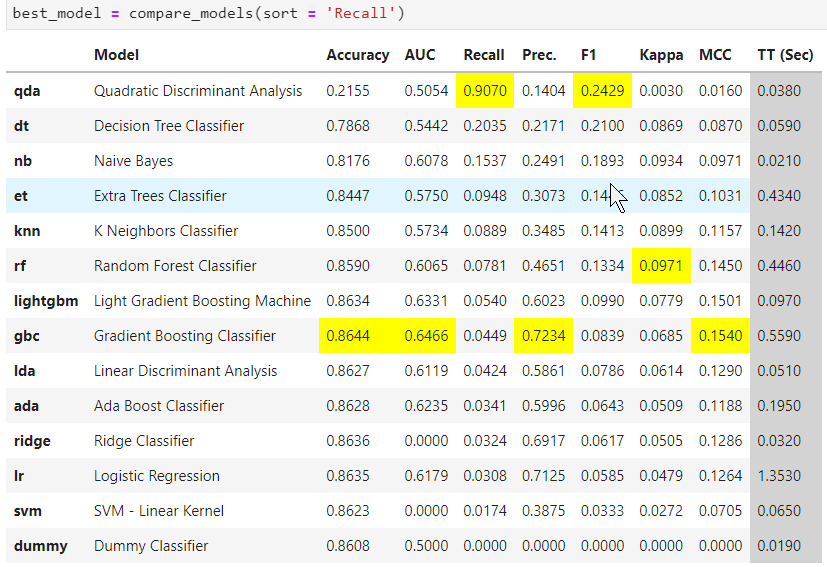
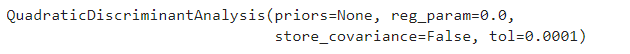

### Lightgbm

In [ ]:
# No es necesario mostrar el detalle porque son los mismos valores que el compare_model:
lightgbm = create_model('lightgbm', verbose=False) 

In [62]:
tuned_lightgbm = tune_model(lightgbm, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6259,0.5318,0.3554,0.1488,0.2098,0.0159,0.0185
1,0.7148,0.5521,0.2397,0.1576,0.1902,0.0260,0.0268
2,0.7133,0.5712,0.3500,0.1981,0.2530,0.0922,0.0979
3,0.7630,0.6218,0.3167,0.2360,0.2705,0.1326,0.1346
4,0.7179,0.5582,0.2667,0.1702,0.2078,0.0463,0.0480
5,0.7422,0.5871,0.2083,0.1634,0.1832,0.0327,0.0331
6,0.7896,0.6161,0.2750,0.2578,0.2661,0.1435,0.1436
7,0.7399,0.5724,0.2750,0.1930,0.2268,0.0762,0.0779
8,0.6960,0.5814,0.2727,0.1587,0.2006,0.0288,0.0304
9,0.7318,0.5881,0.2810,0.1899,0.2267,0.0717,0.0737


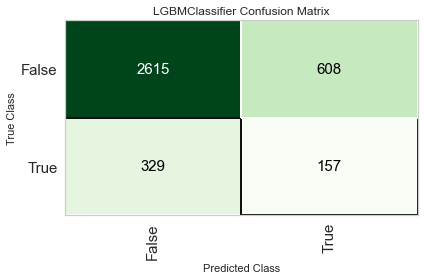

In [63]:
# Está clasificando como Falso muchos valores que en la realidad son verdaderos. Necesitamos reducir esto.
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

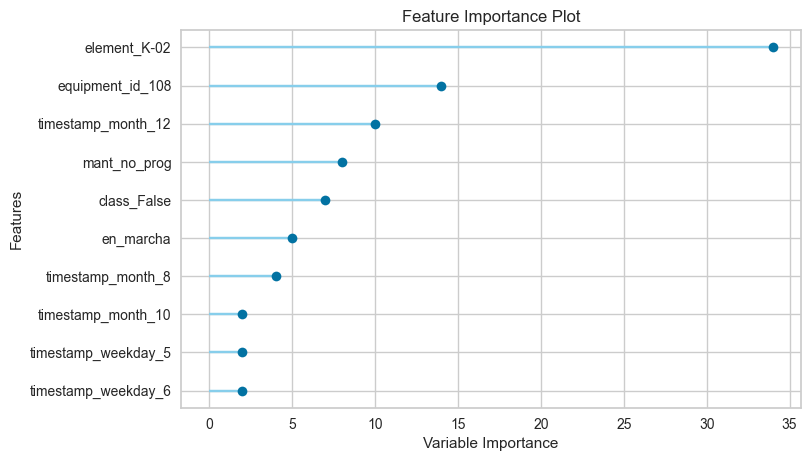

In [64]:
plot_model(tuned_lightgbm, plot='feature')

In [65]:
# aplico el modelo a todo el dataset de nuevo
light_gbm_pred = predict_model(tuned_lightgbm, data);

(34, 14)

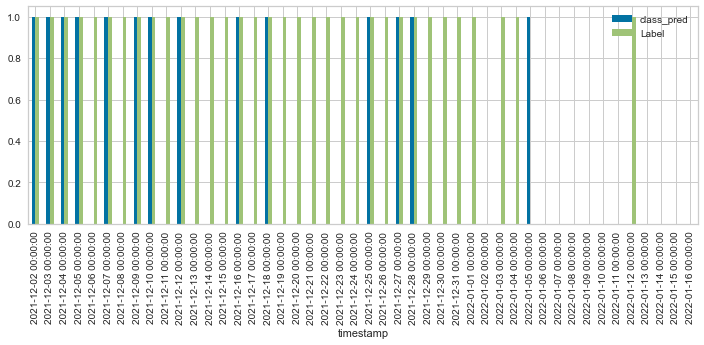

In [67]:
# x_compat=True mejora la forma en que se muestran las fechas
%matplotlib inline
df_filtered = light_gbm_pred[(light_gbm_pred.element=='K-09') & (light_gbm_pred.timestamp > '2021-12-01')]
df_plot = pd.DataFrame.from_dict({'timestamp': df_filtered.timestamp,
                                  'class_pred': 1*df_filtered.class_pred,
                                  'Label': [1 if x == 'True' else 0 for x in df_filtered.Label.to_list()]})
df_plot.plot(kind='bar', x='timestamp', y = ['class_pred', 'Label'], figsize=(12, 4)); #, x_compat=True);
df_plot.Label.sum(), df_plot.class_pred.sum()

### Quadratic Discriminant Analytsis

In [69]:
#print(best_model)
# No es necesario mostrar el detalle porque son los mismos valores que el compare_model:
qda = create_model('qda', verbose=False)

In [70]:
# qda Quadratic Discriminant Analysis: presenta un alto recall cantidad de verdaderos (con mant no prog) estimados
# sobre el total de verdaderos reales.
tuned_qda = tune_model(qda, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6824,0.5730,0.3471,0.1765,0.2340,0.0598,0.0653
1,0.6085,0.5870,0.4380,0.1636,0.2382,0.0436,0.0532
2,0.5445,0.5716,0.5833,0.1691,0.2622,0.0600,0.0841
3,0.4197,0.6096,0.7833,0.1649,0.2725,0.0561,0.1053
4,0.4925,0.5705,0.5917,0.1540,0.2444,0.0311,0.0472
5,0.6532,0.6341,0.5417,0.2097,0.3023,0.1279,0.1534
6,0.5538,0.6167,0.5667,0.1692,0.2605,0.0596,0.0820
7,0.5434,0.5822,0.5500,0.1622,0.2505,0.0461,0.0639
8,0.6509,0.5900,0.4628,0.1911,0.2705,0.0904,0.1057
9,0.6890,0.5550,0.3140,0.1696,0.2203,0.0472,0.0507


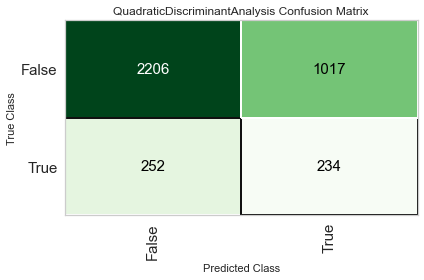

In [71]:
plot_model(tuned_qda, plot = 'confusion_matrix')

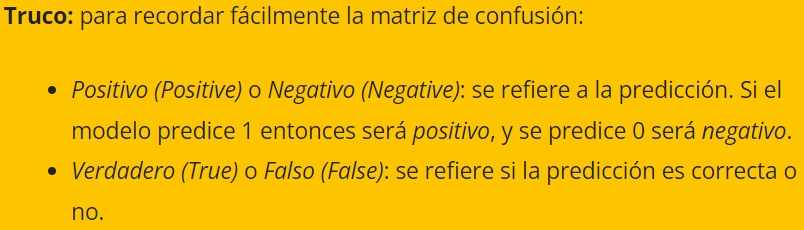

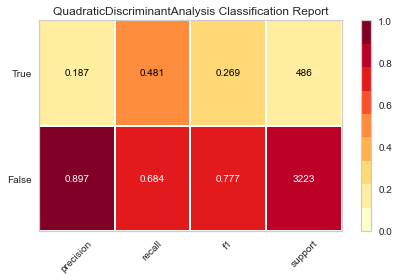

In [77]:
plot_model(tuned_qda, plot="class_report")

In [72]:
# aplico el modelo a todo el dataset de nuevo
qda_pred = predict_model(tuned_qda, data);

(1, 2)

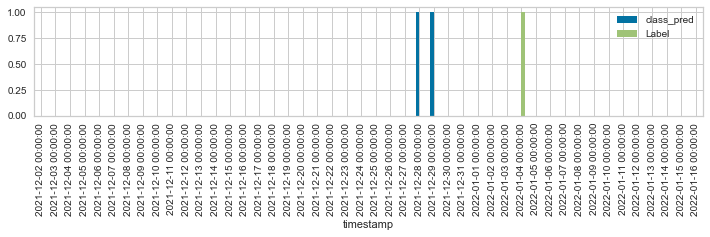

In [76]:
# x_compat=True mejora la forma en que se muestran las fechas
%matplotlib inline
df_filtered = qda_pred[(qda_pred.element=='K-01') & (qda_pred.timestamp > '2021-12-01')]
df_plot = pd.DataFrame.from_dict({'timestamp': df_filtered.timestamp,
                                  'class_pred': 1*df_filtered.class_pred,
                                  'Label': [1 if x == 'True' else 0 for x in df_filtered.Label.to_list()]})
df_plot.plot(kind='bar', x='timestamp', y = ['class_pred', 'Label'], figsize=(12, 2)); #, x_compat=True);
df_plot.Label.sum(), df_plot.class_pred.sum()

In [73]:
# Esta función grafica todo junto:
evaluate_model(tuned_qda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [71]:
# Validar el modelo con los datos que no se utilizaron para entrenamiento
# All of the evaluation metrics are cross validated results based on the training set (70%) only. 
# Now, using the trained model stored in the tuned_xxx variable we will predict against the hold-out sample and 
# evaluate the metrics to see if they are materially different than the CV results.
qda_test = predict_model(tuned_qda);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.6579,0.5905,0.4815,0.1871,0.2694,0.0995,0.1184


In [74]:
qda_pred = predict_model(tuned_qda, data);

In [75]:
qda_pred.head()

,equipment_id,element,timestamp,estado,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_desc,temp_succ,temp_desc,caudal,class,class_pred,Label,Score
0,25,K-01,2013-07-01,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,0.0,0.0,False,False,False,0.5418
1,25,K-01,2013-07-02,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,0.0,0.0,False,False,False,0.5258
2,25,K-01,2013-07-03,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,0.0,0.0,False,False,False,0.5326
3,25,K-01,2013-07-04,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,0.0,0.0,False,False,False,0.5187
4,25,K-01,2013-07-05,NaN,0.0,0.0,0.0,24.0,NaN,NaN,NaN,0.0,0.0,False,False,False,0.5316


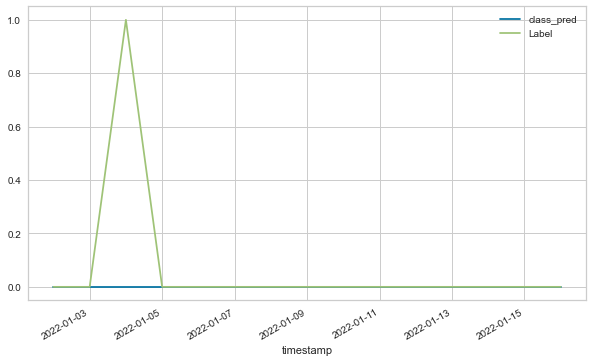

In [110]:
# x_compat=True mejora la forma en que se muestran las fechas
%matplotlib inline
df_filtered = qda_pred[(qda_pred.element=='K-01') & (qda_pred.timestamp > '2022-01-01')]
df_plot = pd.DataFrame.from_dict({'timestamp': df_filtered.timestamp,
                                  'class_pred': 1*df_filtered.class_pred,
                                  'Label': [1 if x == 'True' else 0 for x in df_filtered.Label.to_list()]})
df_plot.plot(x='timestamp', y = ['class_pred', 'Label'], figsize=(10, 6), x_compat=True);

In [72]:
# VER: hace feature engineering automáticamente!!
print(qda_test.columns)
print(qda_test.shape)
qda_test.head()

Index(['mant_prog', 'mant_no_prog', 'en_reserva', 'en_marcha', 'rpm',
       'press_desc', 'temp_succ', 'temp_desc', 'caudal', 'equipment_id_108',
       'equipment_id_116', 'equipment_id_25', 'element_K-02', 'element_K-03',
       'element_K-05', 'element_K-06', 'element_K-07', 'element_K-08',
       'estado_En Funcionamiento', 'estado_En Reserva',
       'estado_Fuera de Servicio', 'estado_not_available', 'class_False',
       'timestamp_month_1', 'timestamp_month_10', 'timestamp_month_11',
       'timestamp_month_12', 'timestamp_month_2', 'timestamp_month_3',
       'timestamp_month_4', 'timestamp_month_5', 'timestamp_month_6',
       'timestamp_month_7', 'timestamp_month_8', 'timestamp_month_9',
       'timestamp_weekday_0', 'timestamp_weekday_1', 'timestamp_weekday_2',
       'timestamp_weekday_3', 'timestamp_weekday_4', 'timestamp_weekday_5',
       'timestamp_weekday_6', 'timestamp_is_month_end_0',
       'timestamp_is_month_start_1', 'class_pred', 'Label', 'Score'],
      dtype

,mant_prog,mant_no_prog,en_reserva,en_marcha,rpm,press_desc,temp_succ,temp_desc,caudal,equipment_id_108,...,timestamp_weekday_2,timestamp_weekday_3,timestamp_weekday_4,timestamp_weekday_5,timestamp_weekday_6,timestamp_is_month_end_0,timestamp_is_month_start_1,class_pred,Label,Score
0,0.0,0.5,0.0,23.5,1118.962891,18.355541,59.193054,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False,True,0.5608
1,0.0,0.0,0.0,24.0,1118.962891,18.355541,59.193054,0.000000,0.000000,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,False,False,0.5374
2,0.0,0.0,0.0,24.0,1175.000000,6.400000,33.799999,22.200001,103.800003,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True,True,0.6395
3,0.0,0.1,0.0,23.9,1150.000000,35.200001,92.099998,29.000000,111.099998,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,False,False,1.0000
4,0.0,0.0,0.0,24.0,1165.000000,31.799999,83.699997,22.299999,119.779999,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,False,False,0.9984


In [112]:
# Se crea el mejor modelo, para luego tunnearlo y compararlo con otros modelos tunneados
# los valores son los mismos que generó la función compare_models()
gbc = create_model('gbc', verbose=False)
# Se tunnea el mejor modelo
tuned_gbc = tune_model(gbc, optimize='Recall')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6420,0.5842,0.4545,0.1839,0.2619,0.0786,0.0926
1,0.6316,0.5589,0.4215,0.1700,0.2423,0.0539,0.0636
2,0.5954,0.5919,0.5250,0.1770,0.2647,0.0722,0.0925
3,0.5387,0.6186,0.6083,0.1718,0.2679,0.0658,0.0939
4,0.6798,0.5767,0.3667,0.1796,0.2411,0.0674,0.0743
5,0.6936,0.5909,0.3083,0.1689,0.2183,0.0476,0.0509
6,0.5803,0.6142,0.5333,0.1725,0.2607,0.0646,0.0847
7,0.5977,0.5531,0.4917,0.1705,0.2532,0.0595,0.0751
8,0.6948,0.6057,0.3884,0.1983,0.2626,0.0949,0.1035
9,0.6960,0.6038,0.3802,0.1966,0.2592,0.0916,0.0995


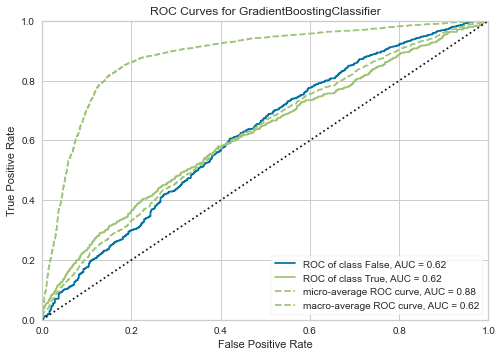

In [60]:
plot_model(tuned_gbc, plot = 'auc')

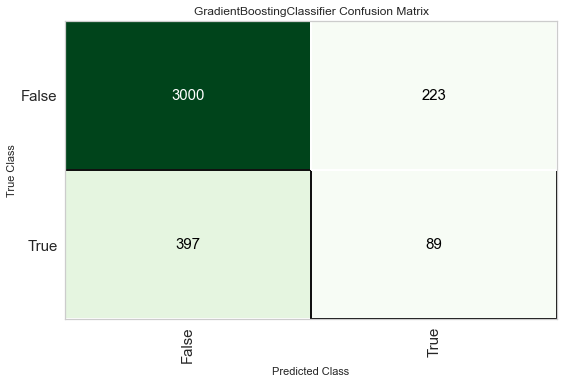

In [61]:
# Está clasificando como Falso muchos valores que en la realidad son verdaderos. Necesitamos reducir esto.
plot_model(tuned_gbc, plot = 'confusion_matrix')

In [113]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [253]:
# No es necesario mostrar el detalle porque son los mismos valores que el compare_model:
# lr logistic regression: presenta una alta precisión calidad de la estimación y Alto accuracy
lr = create_model('lr', verbose=False) 
tuned_lr = tune_model(lr)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8637,0.5773,0.0413,0.7143,0.0781,0.0638,0.1496
1,0.8626,0.6205,0.0248,0.7500,0.0480,0.0394,0.1199
2,0.8659,0.6130,0.0333,1.0000,0.0645,0.0561,0.1698
3,0.8659,0.6573,0.0417,0.8333,0.0794,0.0670,0.1679
4,0.8671,0.5988,0.0667,0.7273,0.1221,0.1012,0.1932
5,0.8647,0.6470,0.0333,0.8000,0.0640,0.0535,0.1459
6,0.8624,0.6304,0.0167,0.6667,0.0325,0.0259,0.0901
7,0.8624,0.5886,0.0167,0.6667,0.0325,0.0259,0.0901
8,0.8590,0.6534,0.0083,0.3333,0.0161,0.0094,0.0329
9,0.8636,0.5946,0.0331,0.8000,0.0635,0.0530,0.1451


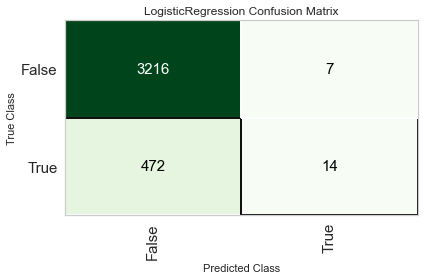

In [254]:
plot_model(tuned_lr, plot = 'confusion_matrix')

# No se hizo:
Predict on unseen data
The predict_model() function is also used to predict on the unseen dataset. The only difference from section 11 above is that this time we will pass the data_unseen parameter. data_unseen is the variable created at the beginning of the tutorial and contains 5% (1200 samples) of the original dataset which was never exposed to PyCaret. (see section 5 for explanation)

# Técnicas de manejo de Datasets Desbalanceados
https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/MachineLearning/4_Clasificacion/Clasificacion.ipynb
* Subsampleo de clase mayoritaria
* SMOTE

In [ ]:
# Subsampleo de la clase mayoritaria
y = df.loc[:, df.columns == 'Survived'] # Survived es la clase positiva
X = df.loc[:, df.columns != 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

train = X_train
train['Survived'] = y_train.Survived.to_list()

positivos = train[train.Survived == 1]
print(len(positivos)) #230
negativos = train[train.Survived == 0]
print(len(negativos)) #339

# se subsamplea la clase mayoritaria:
negativos_sub = negativos.sample(n=len(positivos), random_state=99)
len(negativos_sub) #230

# Se re arma el dataset de entrenamiento con las clases con igual peso:
train_sub = pd.concat([positivos, negativos_sub])
len(train_sub) #460
y_train = train_sub.loc[:, train_sub.columns == 'Survived']
X_train = train_sub.loc[:, train_sub.columns != 'Survived']

# instancia del modelo
logisticRegr = LogisticRegression(max_iter=10000)

# entrenamiento
logisticRegr.fit(X_train, y_train) # En el ejemplo, mejora el recall un poco, que es lo que necesitamos

In [ ]:
# SMOTE
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)

# La primer parte es igual
y = df.loc[:, df.columns == 'Survived']
X = df.loc[:, df.columns != 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Acá cambia
columns = X_train.columns
os_data_X,os_data_y=os.fit_sample(X_train, y_train)

os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])

print("length of oversampled data is ",len(os_data_X))
print("Number of 0 in oversampled data",len(os_data_y[os_data_y['y']==0]))
print("Number of 1",len(os_data_y[os_data_y['y']==1]))
print("Proportion of 0 data in oversampled data is ",len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of 1 data in oversampled data is ",len(os_data_y[os_data_y['y']==1])/len(os_data_X))

# instancia del modelo
logisticRegr = LogisticRegression(max_iter=10000)

# entrenamiento
logisticRegr.fit(os_data_X, os_data_y) # mejora un poco más el recall de 0.63 de una regresión desbalanceada a 0.74

# Time Series Models
https://neptune.ai/blog/select-model-for-time-series-prediction-task